In [452]:
import numpy as np
from matplotlib import pyplot as plt

import os
import glob
import cv2

In [453]:
PIXELSIZE = 32 #28, 32
PIXELTIMES = 1024 # 784, 1024

MAX_IMAGES_PER_CLASS = 110  # Set the maximum number of images per class
TRAIN_SIZE = 3000 # 29 * 110 = 3190

In [454]:
root_dir = "asl_alphabet_train"
image_data = {}

In [455]:
for class_folder in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_path):
        class_images = []
        for image_file in glob.glob(os.path.join(class_path, "*.jpg")):  # Change the file extension as needed
            class_images.append(image_file)
        image_data[class_folder] = class_images

In [456]:
for class_name, images in image_data.items():
    print(f"Class: {class_name}\tCount: {len(images)}")

Class: A	Count: 3000
Class: B	Count: 3000
Class: C	Count: 3000
Class: D	Count: 3000
Class: del	Count: 3000
Class: E	Count: 3000
Class: F	Count: 3000
Class: G	Count: 3000
Class: H	Count: 3000
Class: I	Count: 3000
Class: J	Count: 3000
Class: K	Count: 3000
Class: L	Count: 3000
Class: M	Count: 3000
Class: N	Count: 3000
Class: nothing	Count: 3000
Class: O	Count: 3000
Class: P	Count: 3000
Class: Q	Count: 3000
Class: R	Count: 3000
Class: S	Count: 3000
Class: space	Count: 3000
Class: T	Count: 3000
Class: U	Count: 3000
Class: V	Count: 3000
Class: W	Count: 3000
Class: X	Count: 3000
Class: Y	Count: 3000
Class: Z	Count: 3000


In [457]:
images = []
classes = []
classNumber = 0

for class_name, image_paths in image_data.items():
    class_count = 0  # Initialize a counter for the current class
    for image_path in image_paths:
        if isinstance(image_path, str) and os.path.exists(image_path):
            image = cv2.imread(image_path, 0)
            image = cv2.resize(image, (PIXELSIZE, PIXELSIZE), interpolation= cv2.INTER_LINEAR)

            if image is not None:  # Check if the image was successfully loaded
                images.append(image)
                classes.append(classNumber)
                class_count += 1
                
            if class_count >= MAX_IMAGES_PER_CLASS:
                break  # Stop loading images for the current class

    classNumber += 1

In [458]:
import random

# Combine the two lists into pairs
combined_lists = list(zip(classes, images))

# Shuffle the pairs
random.shuffle(combined_lists)

# Unzip the shuffled pairs back into separate lists
classes, images = zip(*combined_lists)

In [459]:
classes = np.array(classes)
images = np.array(images)

In [460]:
images = images.reshape(-1, PIXELTIMES)

In [461]:
X_train = images[0:TRAIN_SIZE]
y_train = classes[0:TRAIN_SIZE]

X_test = images[TRAIN_SIZE:classes.size]
y_test = classes[TRAIN_SIZE:images.size]

In [462]:
X_train = X_train.T
y_train = y_train.T

X_test = X_test.T
y_test = y_test.T

X_train = X_train / 255.
X_test = X_test / 255.

In [463]:
print(X_train.shape)
print(y_train.shape)

(1024, 3000)
(3000,)


# Neural Network Building

In [464]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((TRAIN_SIZE, PIXELSIZE))
    one_hot_Y[np.arange(TRAIN_SIZE), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [465]:
def init_params():
    W1 = np.random.rand(PIXELSIZE, PIXELTIMES) - 0.5
    b1 = np.random.rand(PIXELSIZE, 1) - 0.5
    W2 = np.random.rand(PIXELSIZE, PIXELSIZE) - 0.5
    b2 = np.random.rand(PIXELSIZE, 1) - 0.5
    return W1, b1, W2, b2

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / TRAIN_SIZE * dZ2.dot(A1.T)
    db2 = 1 / TRAIN_SIZE * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / TRAIN_SIZE * dZ1.dot(X.T)
    db1 = 1 / TRAIN_SIZE * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [466]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 100 == 0:
            predictions = get_predictions(A2)
            print(f"Iteration: {i}\t\tAccuracy: {get_accuracy(predictions, Y) * 100:.2f}%")
    return W1, b1, W2, b2

# Training the Model

In [467]:
W1, b1, W2, b2 = gradient_descent(X_train, y_train, 0.10, 10000)

Iteration: 0		Accuracy: 3.63%
Iteration: 100		Accuracy: 7.43%
Iteration: 200		Accuracy: 8.53%
Iteration: 300		Accuracy: 9.30%
Iteration: 400		Accuracy: 15.13%
Iteration: 500		Accuracy: 21.97%
Iteration: 600		Accuracy: 23.27%
Iteration: 700		Accuracy: 23.00%
Iteration: 800		Accuracy: 30.13%
Iteration: 900		Accuracy: 31.43%
Iteration: 1000		Accuracy: 32.10%
Iteration: 1100		Accuracy: 32.40%
Iteration: 1200		Accuracy: 36.30%
Iteration: 1300		Accuracy: 40.40%
Iteration: 1400		Accuracy: 38.90%
Iteration: 1500		Accuracy: 38.40%
Iteration: 1600		Accuracy: 42.13%
Iteration: 1700		Accuracy: 34.83%
Iteration: 1800		Accuracy: 36.37%
Iteration: 1900		Accuracy: 45.00%
Iteration: 2000		Accuracy: 52.23%
Iteration: 2100		Accuracy: 43.87%
Iteration: 2200		Accuracy: 39.07%
Iteration: 2300		Accuracy: 52.27%
Iteration: 2400		Accuracy: 38.80%
Iteration: 2500		Accuracy: 57.10%
Iteration: 2600		Accuracy: 55.10%
Iteration: 2700		Accuracy: 55.57%
Iteration: 2800		Accuracy: 46.63%
Iteration: 2900		Accuracy: 63.

# Testing the Model

In [468]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [469]:
print(f"Test Accuracy: {get_accuracy(make_predictions(X_test, W1, b1, W2, b2), y_test) * 100:.2f}%")

Test Accuracy: 51.05%


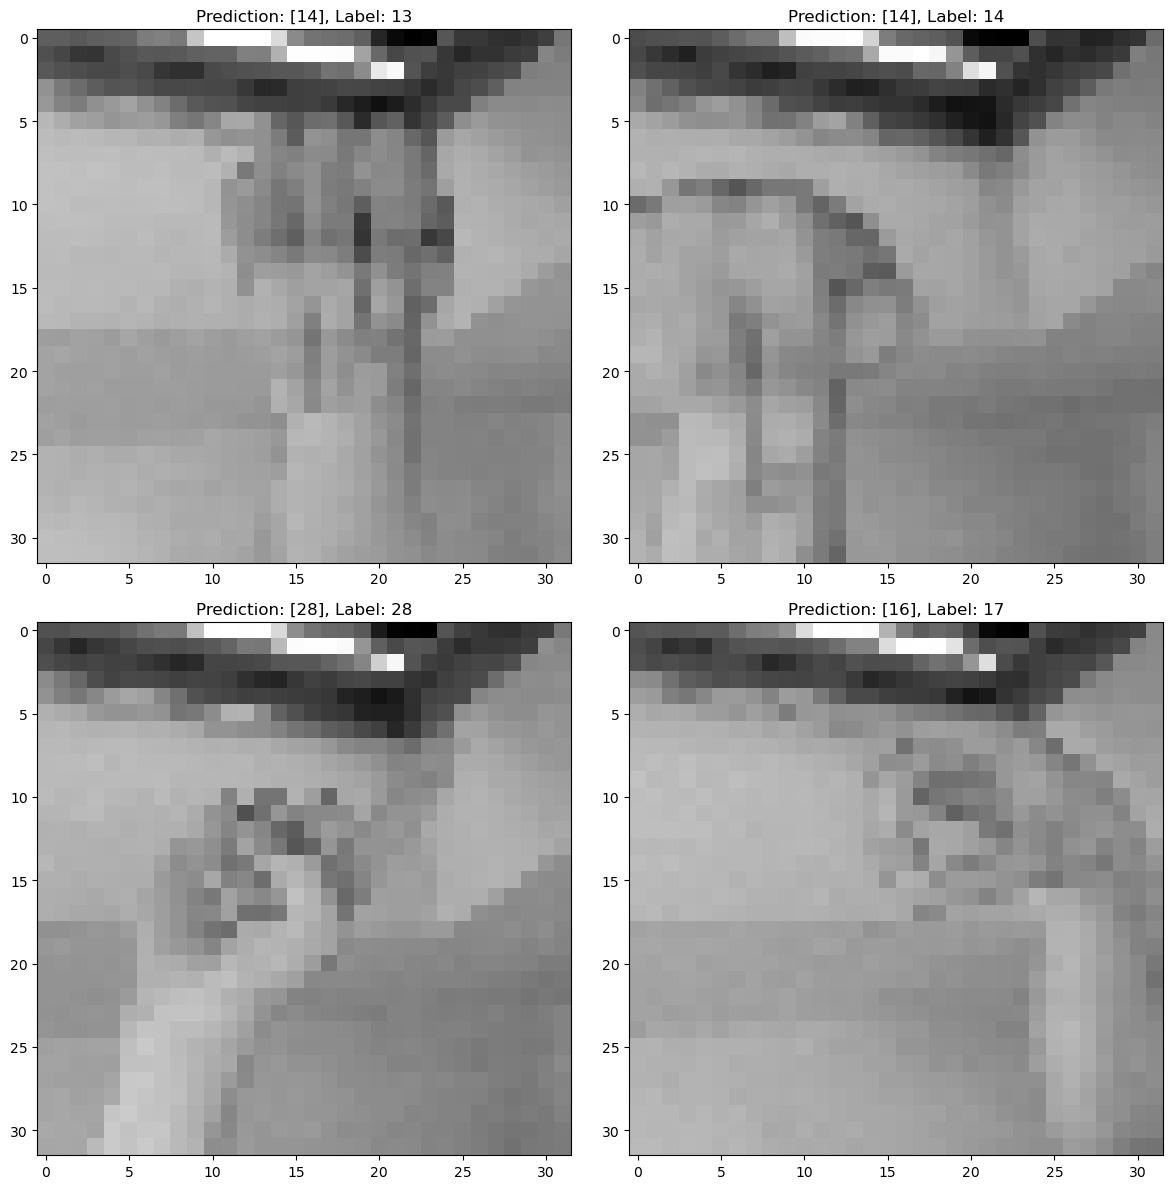

In [470]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Define the indices you want to test
indices = [0, 1, 2, 3]

for i, ax in enumerate(axes.flat):
    if i < len(indices):
        index = indices[i]
        current_image = X_train[:, index, None]
        prediction = make_predictions(current_image, W1, b1, W2, b2)
        label = y_train[index]
        
        current_image = current_image.reshape((PIXELSIZE, PIXELSIZE)) * 255
        ax.imshow(current_image, interpolation='nearest', cmap='gray')
        ax.set_title(f"Prediction: {prediction}, Label: {label}")
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout()
plt.show()